$
    \dfrac{\partial A}{\partial t} = (1 - ic)(1 - |A|^2)A + (i + d)\left(\dfrac{\partial^2 A}{\partial x^2}+\dfrac{\partial^2 A}{\partial y^2}\right) + 4i\left(m_x \cos(q_x x) + m_y \cos(q_y y) \right)\cos(\Omega t)A
$,

$A(t,x,y)$ - signal  
$x,y$ - signal displacement  
$t$ - time  
$c, d$ - alterable parameters  
$i$ - imaginary unit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from tqdm import tqdm
import os
import torch
from matplotlib.colors import LogNorm
import random
import gymnasium as gym

In [29]:
dims = "2D"
setups = ["Q_train", "Q_check", "No_RL"]
setup = setups[2]

print("dims:", dims)
print("setup:", setup)

c = 0.5
gamma = 1. - c*1.j

if dims =="1D":
    d = 0.0
    N = 12871
    x_max = 128.0*np.pi
elif dims =="2D":
    d = 0.01
    N = 755
    x_max = 6*np.pi
else:
    print("wrong dims")

dims: 2D
setup: No_RL


In [30]:
def generate_domains(dims):
    if N%2 == 0:
        print("please make N an odd number")
        return 0, 0
    domain = np.linspace(-x_max, x_max, N)
    dx = (domain[1]-domain[0])
    f_domain = np.fft.fftfreq(domain.shape[0], dx)
    if dims == "1D":
        x = [domain]
        omega = [f_domain]
    elif dims == "2D":
        x = np.meshgrid(domain, domain)
        omega = np.meshgrid(f_domain, f_domain)
    else:
        print("only 1D or 2D in dims")
        return 0, 0
    print("dx:", dx)
    print("k_max: ", f_domain[len(f_domain)//2])
    print("k_min: ", f_domain[len(f_domain)//2+1])
    return x, omega


def initial_conditions(shape):
    A = np.ones(shape, dtype=np.complex128)
    A.imag = 1.
    return A


def plot_data(dims, data):
    if dims == "1D":
        plt.plot(data)
    elif dims == "2D":
        plt.imshow(data)
        plt.colorbar()
    else:
        print("only 1D or 2D in dims")
    return


def add_perturb_1D(A, a, k, func, real, x):
    res = copy(A)
    if real:
        res.real += a*func(k*x)
    else:
        res.imag += a*func(k*x)
    return res


def add_noize(A):
    return A + 0.1*np.random.rand(*A.shape) # np.random.normal for gaussian noize


def save_iteration(A, i, last_iteration): 
    path1 = 'iterations/raw'
    try:
        os.makedirs(path1)
    except FileExistsError:
        pass
    
    path2 = 'iterations/fft'
    try:
        os.makedirs(path2)
    except FileExistsError:
        pass
    B = np.fft.fftshift(np.fft.fft2(A))
    if last_iteration:
        path3 = 'iterations/res'
        try:
            os.makedirs(path3)
        except FileExistsError:
            pass
        np.savetxt(path3+"/res_raw.txt", np.abs(A))

        np.savetxt(path3+"/res_fft.txt", np.abs(B))

    plt.figure(figsize=(10, 10))
    plt.imshow(np.abs(A))
    plt.colorbar()
    plt.title('|A|^2 at timestep {0}'.format(i))
    plt.savefig(path1 + '/{0:0{width}}.png'.format(i, width=3))
    plt.close()
    
    
    plt.figure(figsize=(10, 10))
    plt.imshow( np.abs(B), vmin=0.0, vmax=15.0)
    plt.colorbar()
    plt.title('A spectrum at timestep {0}'.format(i))
    plt.savefig(path2 + '/{0:0{width}}.png'.format(i, width=3))
    plt.close()
    return

def get_1D(data):
    res = data
    if res.ndim == 2:
        res = data[0]
    elif data.ndim < 1 or data.ndim > 2:
        print("either 2 or 1 ndims")
    return res

def check_perturbation(data, x, omega, ampl, freq):
    data = get_1D(data)
    x = get_1D(x)
    omega = get_1D(omega)
    perturb_0 = add_perturb_1D(data, ampl, freq*2*np.pi, np.cos, True, x)
    plt.figure()
    plt.plot(np.abs(perturb_0))
    plt.figure()
    plt.plot(np.fft.fftshift(omega), np.abs(np.fft.fftshift(np.fft.fft(perturb_0))))
    plt.xlim(-freq-1, freq+1)
    

In [31]:
x, omega = generate_domains(dims)

torch_x = []
torch_omega = []
for i in range(len(x)):
    torch_x.append(torch.from_numpy(x[i]))
    torch_omega.append(torch.from_numpy(omega[i]))

dx: 0.04999882207304651
k_max:  9.986990245787313
k_min:  -9.986990245787313


In [32]:
A_init = initial_conditions(x[0].shape)
A_noize = add_noize(A_init)

#plot_data(dims, np.abs(A_noize))
#check_perturbation(A_init, x[0], omega[0], 1., 4.)

In [33]:
def non_linear_step(A, m, q, Om, i, dt):
    temp = torch.empty(A.shape, dtype = torch.cfloat)
    potential = torch.zeros(A.shape, dtype = torch.cfloat)
    for j in range(len(m)):
        if setup in ["No_RL", "Q_train"]:
            potential += m[j]*torch.cos(q[j]*torch_x[j])
        elif setup in ["Q_check"]:
            action = modulation[i%13]
            potential += (action-150)*0.01*torch.cos(q[j]*torch_x[j])
    
    if setup in ["No_RL"]:
        potential *= np.cos(Om*i*dt)
    torch.exp(((1. - torch.abs(A)**2)*gamma + 4.j*potential) * dt, out=temp)
    return A*temp


def computation_loop(A, i, m, q, Om, multiplier, dt):
    fft_func = torch.fft.fft if len(m)==1 else torch.fft.fft2
    ifft_func = torch.fft.ifft if len(m)==1 else torch.fft.ifft2
    A = fft_func(A)
    A = A*multiplier
    A = ifft_func(A)
    A = non_linear_step(A, m, q, Om, i, dt)
    A = fft_func(A)
    A = A*multiplier
    return ifft_func(A)


def iterations(A, num, m, q, Om, a = 0, k = 0, func = 0, real = 0):
    st_perturb = False
    en_perturb = False

    perturb = False if a == 0 else True
    imgs_2D = True if  dims == "2D" else False
    img_1D = True if dims == "1D" else False
    if perturb:
        if imgs_2D:
            print("can't perturb 2D case")
            return 0, 0, 0
        img_1D = False

    dt = 0.04
    if setup in ["No_RL"]:
        period = int(2*np.pi/Om/dt)
        dt = dt if (Om == 0) else 2*np.pi/Om/period
    elif setup in ["Q_train"]:
        period = 1
    elif setup in ["Q_check"]:
        period = 13
    else:
        print("wrong setup")
    n_frames = num//period
    img = 0

    multiplier = torch.empty(torch_omega[0].shape, dtype = torch.cfloat)
    temp = torch.zeros(A.shape, dtype = torch.cfloat)
    for i in range(len(m)):
        temp +=torch_omega[i]**2
    torch.exp(-(d+1.j)*(temp)*dt/2, out=multiplier);

    if setup in ["No_RL", "Q_check"]:
        if not perturb:
            print("dt:", dt)
            print("period:", period, "n_frames:", n_frames)
            elems = tqdm(range(num))
        else:
            elems = range(num)
    elif setup in ["Q_train"]:
        elems = range(num)

    l_array = []
    total_solution = []
    if perturb:
        l_array = np.zeros((2, A.shape[0]), dtype=complex)
    if img_1D:
        total_solution = np.zeros((n_frames, A.shape[0]))
    if imgs_2D:
        total_solution = np.zeros((n_frames, A.shape[0], A.shape[1]))
    

    for i in elems:
        if (img_1D or imgs_2D) and (i%period==period-1):
            total_solution[i//period] = np.copy(np.abs(A.numpy()))
        if imgs_2D and (setup in ["No_RL", "Q_check"]):
            img += A.cpu().detach().numpy()
            if (i%period==period-1):
                save_iteration(img/period, i//period, i//period==n_frames-1)
                img = 0
        
        if i > num*0.01 and perturb:
            if i%period==period-1 and not st_perturb:
                if perturb:
                    A = add_perturb_1D(A, a, k, func, real, torch_x[0])
                st_perturb = True    
            elif i%period==0 and st_perturb and not en_perturb:
                l_array[0] = np.copy(A.cpu().detach().numpy())
                en_perturb = True
            elif i%period==0 and en_perturb:
                l_array[1] = np.copy(A.cpu().detach().numpy())
                break
        
        A = computation_loop(A, i, m, q, Om, multiplier, dt)

    return A, total_solution, l_array

def calc_metric(data):
    if dims == "1D":
        cutoff=2000
        metric = np.sum(data[1:cutoff])/cutoff + np.sum(data[-cutoff:])/cutoff
    elif dims == "2D":
        cutoff=200
        metric = np.sum(data[1:cutoff, -cutoff:])/cutoff**2
        + np.sum(data[1:cutoff, 1:cutoff])/cutoff**2
        + np.sum(data[-cutoff:, -cutoff:])/cutoff**2
        + np.sum(data[-cutoff:, 1:cutoff])/cutoff**2
    else:
        print("Wrong metric")
    return metric

def add_subplot_axes(axx,rect,axisbg='w'):
    fig = plt.gcf()
    box = axx.get_position()
    width = box.width
    height = box.height
    inax_position  = axx.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=axisbg)
    subax.set_xticks([])
    subax.set_yticks([])
    return subax

In [35]:
num = 13*100

A_device = torch.tensor(A_noize)

if dims == "1D":
    A_device, heatmap_1D, lyapunov = iterations(A_device, num = num,
                                            m = [0.0], q = [4.*2*np.pi], Om = 12.16,
                                           )
elif dims == "2D":
    A_device, heatmap_1D, lyapunov = iterations(A_device, num = num,
                                            m = [0., 0.], q = [4.*2*np.pi, 4.*2*np.pi], Om = 12.,
                                           )

dt: 0.04027682889217683
period: 13 n_frames: 100


100%|███████████████████████████████████████| 1300/1300 [01:37<00:00, 13.39it/s]


In [40]:
def plot_mets():
    mets = []

    if dims =="1D":
        res = np.abs(np.fft.fft(heatmap_1D, axis=1)[:, :])
        for i in range(res.shape[0]):
            metric = calc_metric(res[i])
            mets.append(metric)
    elif dims =="2D":
        heatmap_1D_new = np.abs(np.fft.fft2(heatmap_1D))
        for i in range(heatmap_1D_new.shape[0]):
            res = np.abs(np.fft.fft2(heatmap_1D_new[i]))
            metric = calc_metric(res)
            mets.append(metric)

    plt.figure(figsize=(10,7))
    plt.plot(np.array(mets), lw=4)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.ylabel("$\int(\mathscr{F}$|A|), |k|<2", fontsize=20)
    plt.xlabel("time modulation periods", fontsize=20)
    plt.tight_layout()
    plt.grid()
    return

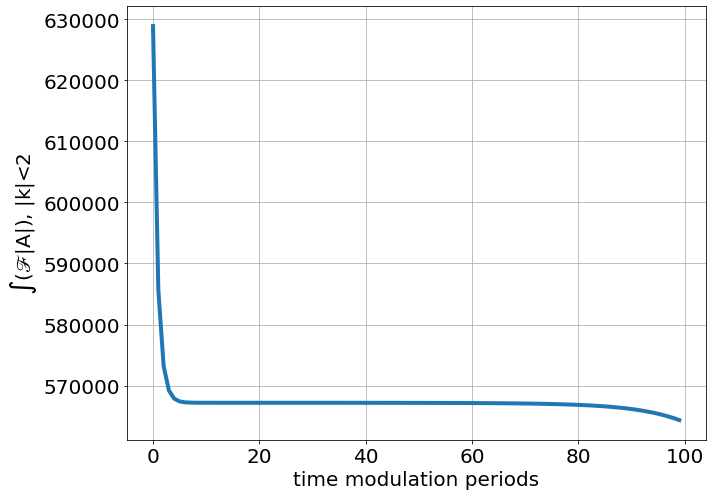

In [41]:
plot_mets()

In [42]:
def plot_1D_heatmap(heatmap_1D):
    plt.figure(figsize=(10,10))
    plt.imshow(np.abs(heatmap_1D[:,1000:1000+heatmap_1D.shape[1]//8]), aspect='auto', origin="lower", cmap='binary_r', vmin=0.85, vmax=1.1)
    #plt.imshow(np.abs(heatmap_1D[:,:]), aspect='auto', origin="lower", cmap='binary_r', vmin=0.85, vmax=1.1)
    cb = plt.colorbar()
    cb.set_label(label='|A|',size=25)
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(20)
    ax = plt.gca()
    #plt.xlim(0, 32)
    ax.set_xticks(np.linspace(0, heatmap_1D.shape[1]/8, 9), np.linspace(0, int(2*x[0][-1]/8/np.pi), 9).astype(int), fontsize=20);
    ax.set_yticks(np.linspace(0, heatmap_1D.shape[0], 9), np.linspace(0, heatmap_1D.shape[0], 9).astype(int), fontsize=20);
    plt.xlabel("x in units of $\pi$", fontsize=25)
    plt.ylabel("t in time modulation periods", fontsize=25)
    plt.tight_layout()
    plt.savefig("unmodulated_x.pdf", format='pdf')
    
    
    plt.figure(figsize=(10,10))
    res = np.abs(np.fft.fft(heatmap_1D, axis=1)[:, :])

    #for i in range(res.shape[0]):
    #    res[i] = np.fft.fftshift(res[i])

    plt.imshow(res[:, : heatmap_1D.shape[1]//2], origin='lower', aspect='auto',  cmap='binary_r', vmin=0, vmax=25)
    cb = plt.colorbar()
    cb.set_label(label="$|\mathscr{F}$ (|A|)|",size=25)
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(20)

    ax = plt.gca()
    plt.xlabel("k", fontsize=25)
    plt.ylabel("t in time modulation periods", fontsize=25)
    ax.set_xticks(np.linspace(0, heatmap_1D.shape[1]//2, 5), np.linspace(0, int(omega[0][len(omega[0])//2]), 5).astype(int), fontsize=20);
    ax.set_yticks(np.linspace(0, heatmap_1D.shape[0], 9), np.linspace(0, heatmap_1D.shape[0], 9).astype(int), fontsize=20)
    plt.tight_layout()
    plt.savefig("unmodulated_sp.pdf", format='pdf')
    return

def plot_2D():
    path = "./iterations/res/"
    paths = [path]
    data_raw = []
    data_fft = []
    for path in paths:
        data_raw.append(np.loadtxt(path+"res_raw.txt"))
        data_fft.append(np.loadtxt(path+"res_fft.txt"))

    vmax = 5
    val = 25
    every = 1
    plt.tight_layout()
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    lenx = data_raw[0].shape[0]
    leny = data_raw[0].shape[1]
    ax.imshow(data_raw[0][:, :], cmap='binary_r', vmin=-0.2)
    ax.set_xticks([0, lenx//2, lenx], [-2, 0, 2], fontsize=30)
    plt.xlabel("x in units of $\pi$", fontsize=30)

    ax.set_yticks([0, leny//2, leny], [-2, 0, 2], fontsize=30)
    plt.ylabel("y in units of $\pi$", fontsize=30)

    rect = [0.5,0.5,0.45,0.45]
    ax1 = add_subplot_axes(ax,rect)
    ax1.imshow(data_fft[0][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="binary_r")
    ax1.set_xticks([0, (lenx-2*val)/2, lenx-2*val], [-8, 0, 8], fontsize=30)
    ax1.set_xlabel("$k_x$", fontsize=30)
    ax1.set_yticks([0, (leny-2*val)/2, leny-2*val], [-8, 0, 8], fontsize=30)
    ax1.set_ylabel("$k_y$", fontsize=30)

    #ax.text(60//3,680//3,'2D, RL modulation\nq = 4.0', fontsize=36, color = "white", weight="bold")
    plt.savefig('unmodulated_2d.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

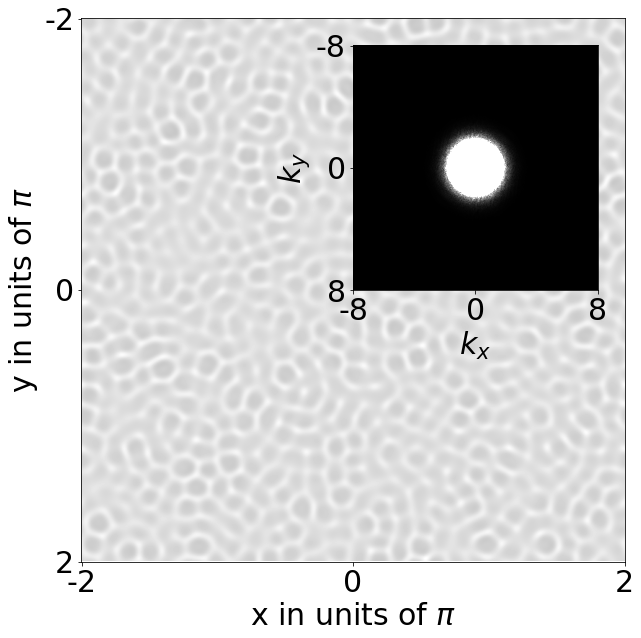

In [43]:
if dims =="1D":
    plot_1D_heatmap(heatmap_1D)
elif dims =="2D":
    plot_2D()

# Lyapunov

In [44]:
# sp_ind = 3217
# offset = 8

# ks = omega[0][:len(omega[0])//2][omega[0][:len(omega[0])//2]<1.2][::offset]
# num = 8000
# q = 4.
# harmonics = [0, q, -q, -2*q]
# n_mat = 4*len(harmonics)
# funcs = [torch.sin, torch.cos]
# reals = [True, False]

In [45]:
# totals = []

# for k in tqdm(ks):
#     for harm in harmonics:
#         for real in reals:
#             for func in funcs:
#                 A_device = torch.tensor(A_init)
#                 _, _, lyapunov = iterations(A_device, num = num,
#                             m = [0.72], q = [q*2*np.pi], Om = 12.16,
#                             #m = [0.38], q = [4.*2*np.pi], Om = 10.4,
#                             a = 0.1, k = (k+harm)*2.*np.pi,
#                             func = func, real = real)
#                 totals.append(np.copy(lyapunov))

In [46]:
# def fill_matrix(ind, sp_ind, val):
#     inds = [ind*offset, -ind*offset, 
#             sp_ind+ind*offset, -sp_ind-ind*offset,
#             sp_ind-ind*offset, -sp_ind+ind*offset,
#             2*sp_ind-ind*offset, -2*sp_ind+ind*offset]

#     m = np.zeros((n_mat,n_mat))
#     for i in range(n_mat):
#         for j in range(len(inds)):
#             m[2*j, i] = np.fft.fft(totals[ind*n_mat+i][val]).real[inds[j]]
#             m[2*j+1, i] = np.fft.fft(totals[ind*n_mat+i][val]).imag[inds[j]]

#     return m

# def get_lyapunov_coefs():
#     l_components = np.zeros((len(ks)-1, 16))

#     for i in tqdm(range(1, len(ks))):
#         m0 = fill_matrix(i, sp_ind, 0)
#         mT = fill_matrix(i, sp_ind, 1)
#         m_new = np.matmul(np.linalg.inv(m0), mT)
#         lambdas, _ = np.linalg.eig(m_new)
#         res = (np.log(lambdas)/0.6).real
#         l_components[i-1] = np.copy(res)
#     return l_components

# def get_lyapunov_graph(coefs, n_plots):
#     sorted_coefs = np.sort(coefs, axis=1)
#     st_point = 8
#     plt.figure(figsize=(10,7))
#     for i in range(n_plots):
#         plt.plot(ks[st_point::1], sorted_coefs[st_point-1::1, n_mat-1-2*i], lw=4)
#     plt.xlim(ks[st_point], ks[-1])
#     plt.plot(ks, np.zeros(len(ks)), 'k--', label="y=0", lw=4)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.ylabel("lyapunov exponents", fontsize=20)
#     plt.xlabel("perturbation mode", fontsize=20)
#     plt.tight_layout()
#     plt.grid()
#     plt.legend(fontsize=20)
#     plt.savefig("modulated_lambda.pdf", format='pdf')
#     return

In [47]:
# coefs = get_lyapunov_coefs()

In [48]:
# get_lyapunov_graph(coefs, 6)

# 2 by 2 graph

In [49]:
# p4 = "./iterations/strong/"
# p1 = "./iterations/no/"
# p2 = "./iterations/axis/"
# p3 = "./iterations/weak/"
# paths = [p1,p2,p3,p4]
# data_raw = []
# data_fft = []
# for path in paths:
#     data_raw.append(np.loadtxt(path+"res_raw.txt"))
#     data_fft.append(np.loadtxt(path+"res_fft.txt"))

In [50]:
# vmax = 25
# val = 40
# every = 1
# # plt.tight_layout()
# fig, ax = plt.subplots(2, 2, figsize=(30,30))
# ax[0,0].imshow(data_raw[0])
# ax[0,0].set_xticks([])
# ax[0,0].set_yticks([])
# rect = [0.5,0.5,0.45,0.45]
# ax1 = add_subplot_axes(ax[0,0],rect)
# ax1.imshow(data_fft[0][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
# ax[0,0].text(10,190,'m = 0', fontsize=56, color = "white", weight="bold")

# ax[0,1].imshow(data_raw[1])
# ax[0,1].set_xticks([])
# ax[0,1].set_yticks([])
# rect = [0.5,0.5,0.45,0.45]
# ax2 = add_subplot_axes(ax[0,1],rect)
# ax2.imshow(data_fft[1][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
# ax[0,1].text(10,190,'$\mathbf{m_x}$ = 0.3\nq = 2.0\n$\Omega$=2.0', fontsize=56, color = "white", weight="bold")

# ax[1,0].imshow(data_raw[2])
# ax[1,0].set_xticks([])
# ax[1,0].set_yticks([])
# rect = [0.5,0.5,0.45,0.45]
# ax3 = add_subplot_axes(ax[1,0],rect)
# ax3.imshow(data_fft[2][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
# ax[1,0].text(10,190,'m = 0.18\nq = 2.0\n$\Omega$=2.0', fontsize=56, color = "white", weight="bold")

# ax[1,1].imshow(data_raw[3])
# ax[1,1].set_xticks([])
# ax[1,1].set_yticks([])
# rect = [0.5,0.5,0.45,0.45]
# ax4 = add_subplot_axes(ax[1,1],rect)
# ax4.imshow(data_fft[3][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
# ax[1,1].text(10,190,'m = 0.3\nq = 2.0\n$\Omega$=2.0', fontsize=56, color = "white", weight="bold")
# plt.savefig('2d.png')

# Q-table approach - m(t)

In [51]:
setup = "Q_train"
n_bins = 40

class NLSE_env(gym.Env):

    def __init__(self, m = ''):
        self.action_space_m = gym.spaces.Discrete(301, start=0)
        self.action_space_q = gym.spaces.Discrete(51, start=0)
        self.T_max = 13
        self.observation_space = gym.spaces.Discrete(n_bins*self.T_max, start=0)

    def reset(self):
        self.obs = np.copy(A_noize)
        if dims == "1D":
            state = np.abs(np.fft.fft(np.abs(self.obs)))
        elif dims == "2D":
            state = np.abs(np.fft.fft2(np.abs(self.obs)))

        self.metric = calc_metric(state)
        self.prev_metric = self.metric
        return 0, self.metric

    def step(self, action_m, action_q, time):
        m = (action_m-150)*0.01
        q = action_q*0.1

        A = torch.tensor(self.obs)
        if dims == "1D":
            A, heatmap_1D, _ = iterations(A, num = 1, Om = 0, m = [m], q = [q*2*np.pi])
            res = np.abs(np.fft.fft(heatmap_1D, axis=1)[:, :])
        elif dims == "2D":
            A, heatmap_1D, _ = iterations(A, num = 1, Om = 0, m = [m, m], q = [q*2*np.pi, q*2*np.pi])
            res = np.abs(np.fft.fft2(heatmap_1D))
            
        metric = calc_metric(res[-1])
        
        reward = 1./(abs(self.prev_metric-metric)+0.01)*time*time/1000. if metric < self.metric else -100.*time*time
        self.prev_metric = metric

        self.obs = A.numpy()
        return reward, metric
        

In [52]:
env = NLSE_env()

In [53]:
#q_table = np.zeros([env.observation_space.n, env.action_space_m.n, env.action_space_q.n])
q_table = np.zeros([env.observation_space.n, env.action_space_m.n])
print(q_table.shape)

(520, 301)


In [54]:
def ind_from_state(state, low_freq):
    val = int(low_freq) if low_freq < 39 else 39
    ind = val + state * n_bins
    return int(ind)

In [60]:
Alpha = 0.1
Gamma = 0.6
Epsilon = -0.1
setup = "Q_train"

n_episodes = 4000
n_steps = 2500
actions_m = np.zeros(n_steps)
#actions_q = np.zeros(n_steps)


stop = False

q = 4
for episode in tqdm(range(n_episodes)):
    if n_episodes==1:
        q_table = np.copy(backup)
    else:
        q_backup = np.copy(q_table)
    st, low_freq = env.reset()
    ind = ind_from_state(st, low_freq)
    reward = 0
    for step in range(n_steps):
        crit_val = random.uniform(0, 1)
        if n_episodes==1:
            action_m = int(actions_backup_m[step])
            action_q = int(actions_backup_q[step])
        elif crit_val < Epsilon:
            action_m = env.action_space_m.sample()
            #action_q = env.action_space_q.sample()
            action_q = q*10
        else:
            #action_m, action_q = np.argwhere(q_table[ind]==q_table[ind].max())[0]
            action_m = np.argwhere(q_table[ind]==q_table[ind].max())[0][0]
            action_q = q*10

        actions_m[step] = action_m
        #actions_q[step] = action_q

        reward, low_freq = env.step(action_m, action_q, step)
        #old_value = q_table[ind, action_m, action_q]
        old_value = q_table[ind, action_m]
        new_ind = ind_from_state((step+1)%env.T_max, low_freq)
        next_max = np.max(q_table[new_ind])

        new_value = (1 - Alpha) * old_value + Alpha * (reward + Gamma * next_max)
        #q_table[ind, action_m, action_q] = new_value
        q_table[ind, action_m] = new_value

        ind = new_ind

    if low_freq < 2.5:
        print("breaking:", low_freq)
        actions_backup_m = np.copy(actions_m)
        modulation = actions_backup_m[-4*13:-3*13]
        #action_backup_q = np.copy(actions_q)
        break
    if n_episodes == 1:
        print(low_freq)

print("Training finished.\n")


  0%|                                                  | 0/4000 [03:51<?, ?it/s]

breaking: 1.8879883090041465
Training finished.



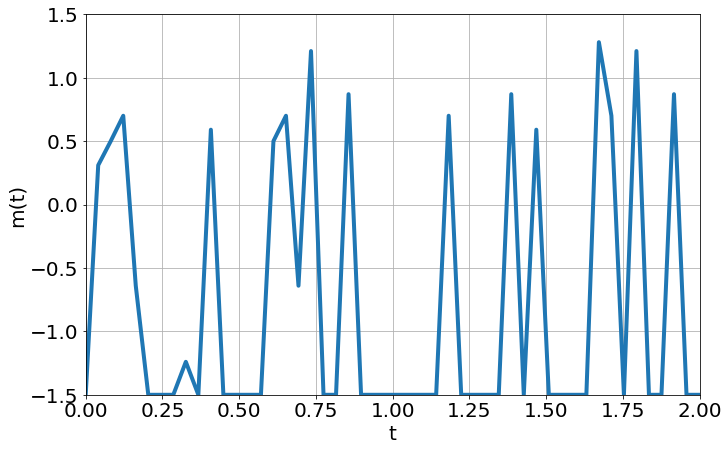

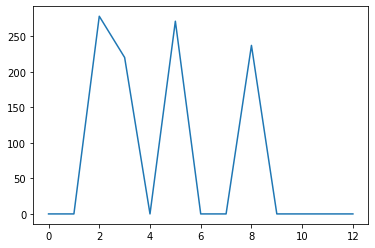

In [61]:
plt.figure(figsize=(11,7))

plt.plot(np.linspace(0, 4*13*0.04, 4*13), (np.array(actions_backup_m[-7*13:-3*13])-150)*0.01, lw=4)
#plt.plot(np.linspace(0, 4*13*0.04, 4*13), 0.72*np.cos(12.16*np.linspace(0, 4*13*0.04, 4*13)), lw=4)

plt.ylim(-1.5,1.5)
plt.xlim(0,2)
plt.ylabel("m(t)", fontsize=20)
plt.xlabel("t", fontsize=20)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("modulation.pdf", format='pdf')
plt.figure()
plt.plot(modulation)

In [57]:
setup = "Q_check"

num = 13*100

A_device = torch.tensor(A_noize)

if dims == "1D":
    A_device, heatmap_1D, lyapunov = iterations(A_device, num = num,
                                            m = [0.0], q = [4.*2*np.pi], Om = 12.16,
                                           )
elif dims == "2D":
    A_device, heatmap_1D, lyapunov = iterations(A_device, num = num,
                                            m = [0., 0.], q = [4.*2*np.pi, 4.*2*np.pi], Om = 12.,
                                           )

dt: 0.04
period: 13 n_frames: 100


100%|███████████████████████████████████████| 1300/1300 [01:37<00:00, 13.29it/s]


<Figure size 432x288 with 0 Axes>

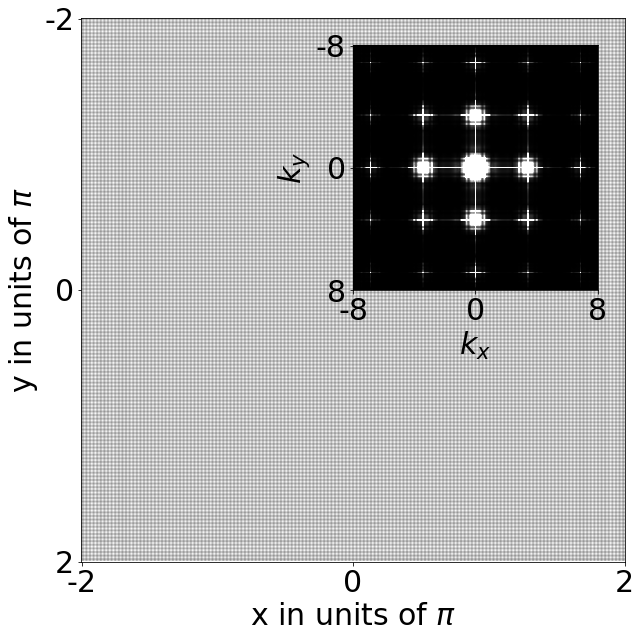

In [58]:
if dims =="1D":
    plot_1D_heatmap(heatmap_1D)
elif dims =="2D":
    plot_2D()

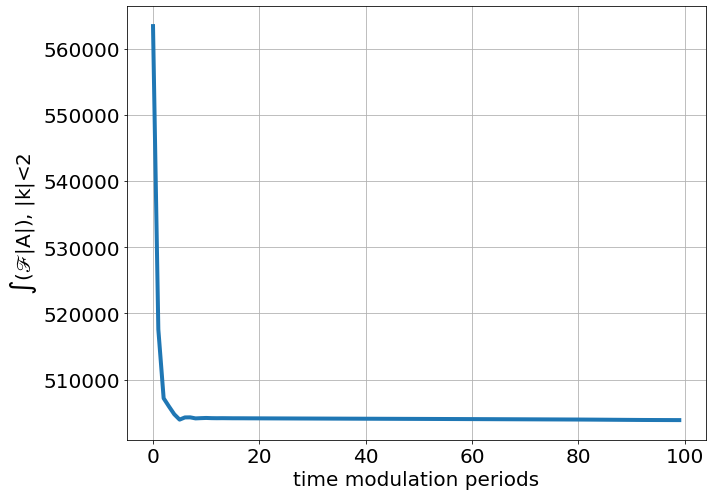

In [59]:
plot_mets()